In [107]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
data = np.load("DK_time_series_for_new_loss.npy")
data = data[0] + data[3]

train = data[:10000]
test =  data[10000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [109]:
processNoise = 1e-4 
processNoiseVariance = 1e-4
measurementSigma = 0.5
dt = 2.

In [110]:
import filterpy.kalman
import filterpy.common

In [9]:
# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=1,      # Размер вектора состояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 1х1
filter.F = np.array([[1.0]])


# Матрица наблюдения - dim_z на dim_x - 1x1
filter.H = np.array([[1.0]])

# Ковариационная матрица ошибки модели
filter.Q = processNoise 

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[8.0]])

In [10]:
k = 5
for i in range(10000):
    filter.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    for _ in range(k):
        f = filter
        f.predict()
        f.update(f.x) 
    predicted.append(f.x)
    filter.update(test_norm[j]) 


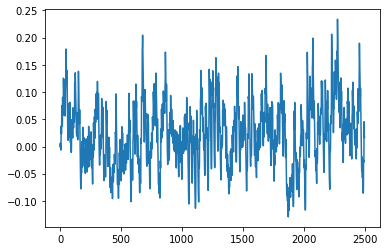

In [11]:
plt.plot(predicted)

In [12]:
len(predicted)

2500

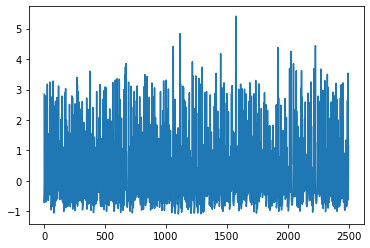

In [19]:
plt.plot(test_norm)

In [16]:
# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=2,      # Размер вектора стостояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 2х2
filter.F = np.array([[1,   dt],
                     [0,   1.0]])


# Матрица наблюдения - dim_z на dim_x - 1x2
filter.H = np.array([[1.0, 0.0]])

filter.Q = np.array([[dt**2,       dt],
           [   dt,      1.0]]) * processNoise

# Начальное состояние.
filter.x = np.array([0.0, 0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[8.0, 0.0],
                    [0.0, 8.0]])

In [17]:
k = 5
for i in range(10000):
    filter.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    for _ in range(k):
        f = filter
        f.predict()
        f.update(f.x[0]) 
    predicted.append(f.x)
    filter.update(test_norm[j]) 


In [28]:
for i in range(10000):
    filter.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    filter.predict()
    filter.update(test_norm[j])    
    predicted.append(filter.x)


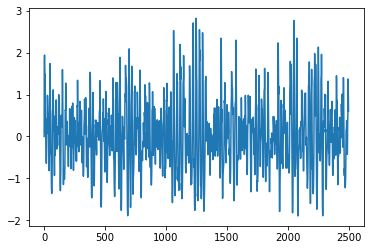

In [18]:
plt.plot(np.array(predicted)[:, 0])

In [111]:
# Создаём объект KalmanFilter
f1 = filterpy.kalman.KalmanFilter(dim_x=3,      # Размер вектора стостояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 3х3
f1.F = np.array([[1.,   dt,     (dt**2)/2],
                     [0,   1.,    dt],
                     [0,   0,      1.]])


# Матрица наблюдения - dim_z на dim_x - 1x3
f1.H = np.array([[1., 0., 0.]])

# Ковариационная матрица ошибки модели
f1.Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt, var=processNoiseVariance)

# Ковариационная матрица ошибки измерения - 1х1
f1.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
f1.x = np.array([0.0, 0.0, 0.0])

# Ковариационная матрица для начального состояния
f1.P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])

In [98]:
def KalmanCopy(f, n, m):
    f_copy = filterpy.kalman.KalmanFilter(dim_x=n, dim_z=m)
    f_copy.F = f.F.copy()
    f_copy.H = f.H.copy()
    f_copy.Q = filterpy.common.Q_discrete_white_noise(dim=n, dt=dt, var=processNoiseVariance)
    f_copy.R = f.R.copy()
    f_copy.x = f.x.copy()
    f_copy.P = f.P.copy()
    return f_copy

In [88]:
test_norm


tensor([ 2.8452, -0.7103, -0.6065,  ..., -0.3442,  0.0035,  1.1590])

In [99]:
k = 10
for i in range(10000):
    f1.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    f = KalmanCopy(f1, 3, 1)
    print("F1", f1.x)
    for _ in range(k):
        f.predict()
        #f.update(f.x[0]) 
        print("F", f.x)
    predicted.append(f.x)
    print("F1", f1.x)
    if j == 3:
        break
    f1.update(test_norm[j]) 


F1 [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F1 [4.73161352e-11 0.00000000e+00 0.00000000e+00]
F1 [0.00028449 0.         0.        ]
F [0.00028449 0.         0.        ]
F [0.00028449 0.         0.        ]
F [0.00028449 0.         0.        ]
F [0.00028449 0.         0.        ]
F [0.00028449 0.         0.        ]
F [0.00028449 0.         0.        ]
F [0.00028449 0.         0.        ]
F [0.00028449 0.         0.        ]
F [0.00028449 0.         0.        ]
F [0.00028449 0.         0.        ]
F1

In [112]:
for i in range(10000):
    f1.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    f1.predict()
    f1.update(test_norm[j])    
    predicted.append(f1.x)


In [96]:
predicted

[array([2.83637126, 2.12728132, 0.70909614]),
 array([-0.68238806, -3.26461344, -1.547013  ]),
 array([-1.12962707, -1.40372412, -0.40491625]),
 array([-0.99464687, -0.64160756, -0.12873823]),
 array([-0.70682957, -0.27477993, -0.03982317]),
 array([-0.30950633, -0.05747834, -0.00380622]),
 array([0.34394031, 0.13181738, 0.0175345 ]),
 array([2.01933346, 0.48417529, 0.0498367 ]),
 array([0.87159158, 0.10319953, 0.00173194]),
 array([ 0.23637956, -0.07154739, -0.0163281 ]),
 array([-0.00765527, -0.11852816, -0.01781144]),
 array([ 0.19183103, -0.05455618, -0.00732423]),
 array([1.64026893, 0.26460655, 0.02810675]),
 array([ 0.53956075, -0.03839806, -0.01007696]),
 array([-0.16006599, -0.18696654, -0.02370887]),
 array([-0.51404576, -0.22005063, -0.02218957]),
 array([-0.57539437, -0.17455172, -0.0126691 ]),
 array([-3.70455783e-01, -7.69490425e-02,  3.55710727e-04]),
 array([0.17588544, 0.07214393, 0.01608396]),
 array([1.52671558, 0.35342584, 0.04250245]),
 array([0.65790582, 0.0861065

In [114]:
dif = np.array(predicted)[:, 0] - np.array(test_norm)

plt.figure(figsize = (16, 9))
plt.plot(dif)
plt.title("The difference between prediction and test, k = 1")

plt.figure(figsize = (16, 9))
plt.plot(test_norm, label='true')
plt.plot(np.array(predicted)[:, 0],  linestyle = '--', label='predicted')
plt.title("k = 1")
plt.legend()

Text(0.5, 1.0, 'The difference between prediction and test, k = 1')

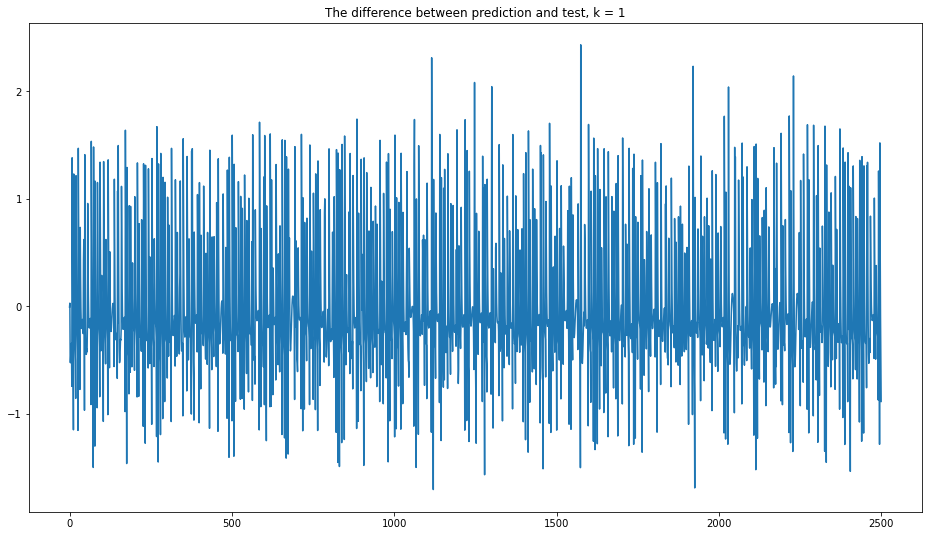

In [115]:
plt.figure(figsize = (16, 9))
plt.plot(dif)
plt.title("The difference between prediction and test, k = 1")

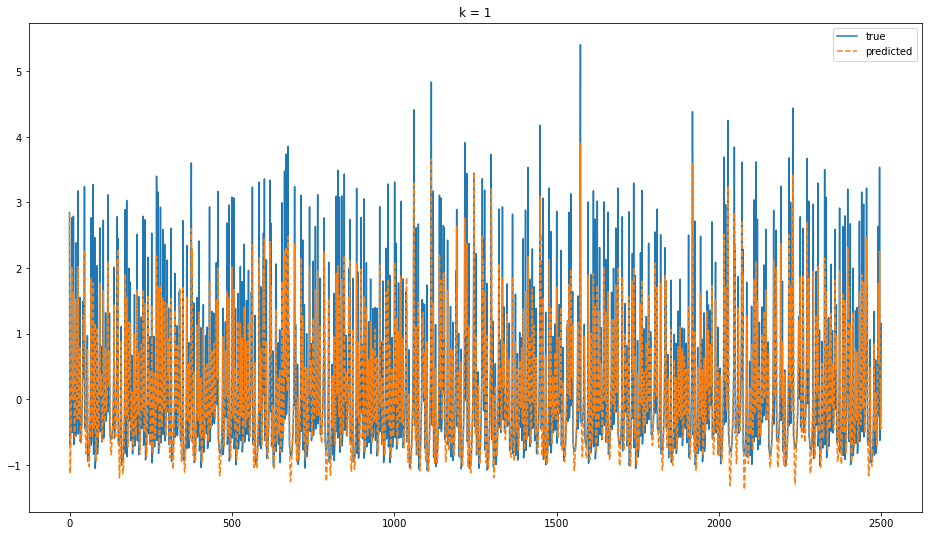

In [113]:
plt.figure(figsize = (16, 9))
plt.plot(test_norm, label='true')
plt.plot(np.array(predicted)[:, 0],  linestyle = '--', label='predicted')
plt.title("k = 1")
plt.legend()

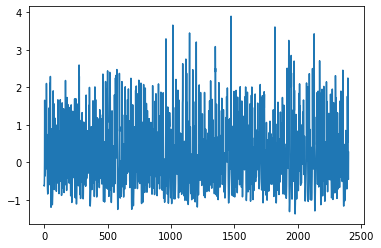

In [106]:
plt.plot(np.array(predicted)[:, 0][100:])

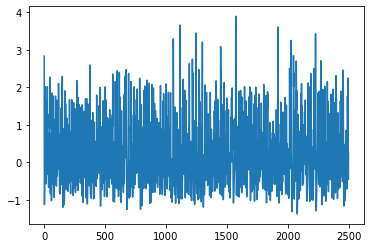

In [105]:
plt.plot(np.array(predicted)[:, 0])

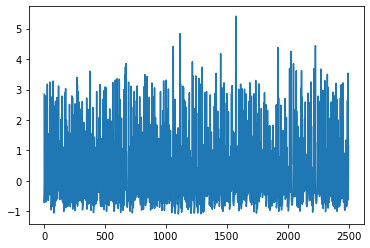

In [44]:
plt.plot(test_norm)

In [ ]:
np.array(predicted)[:, 0]*std + mean

In [45]:
((((np.array(predicted)[:, 0]*std+mean) - test)**2).mean())**0.5

0.4060305386962941

# FHN

In [116]:
def FHN(self, X):
        x1, y1, x2, y2 = X
        return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                b1*x1 - c*y1,
                x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                b2*x2 - c*y2
               ]

In [117]:
a = -0.025794
c = 0.02
b1 = 0.0135
b2 = 0.0065
k = 0.129
sigma = 1
alpha = 0.35
eps = 1
beta = 10e-8
q=1.6

In [119]:
sol = solve_ivp(FHN, [0, 250000], [-0.1, 0.1, -0.1, -0.1], 
                t_eval=np.array(range(0, 250000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

In [120]:
data = sol.y[0]

train = data[:10000]
test =  data[10000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std
train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [92]:
# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=1,      # Размер вектора состояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 1х1
filter.F = np.array([[1.0]])


# Матрица наблюдения - dim_z на dim_x - 1x1
filter.H = np.array([[1.0]])

# Ковариационная матрица ошибки модели
filter.Q = processNoise 

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[8.0]])

In [93]:
for i in range(len(train_norm)):
    filter.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    filter.predict()
    filter.update(test_norm[j])    
    predicted.append(filter.x)


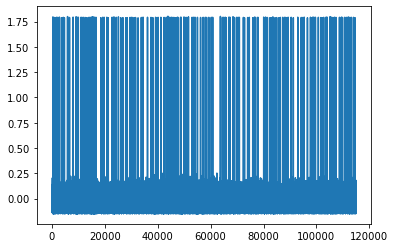

In [94]:
plt.plot(predicted)

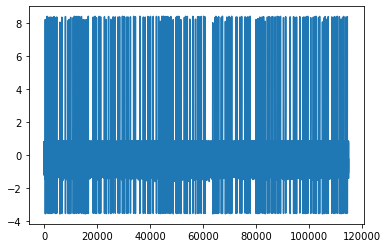

In [95]:
plt.plot(test_norm)

In [96]:
((((np.array(predicted)[:, 0]*std+mean) - test)**2).mean())**0.5

0.11356888598930141

In [97]:
# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=2,      # Размер вектора стостояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 2х2
filter.F = np.array([[1,   dt],
                     [0,   1.0]])


# Матрица наблюдения - dim_z на dim_x - 1x2
filter.H = np.array([[1.0, 0.0]])

filter.Q = np.array([[dt**2,       dt],
           [   dt,      1.0]]) * processNoise

# Начальное состояние.
filter.x = np.array([0.0, 0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[8.0, 0.0],
                    [0.0, 8.0]])

In [98]:
for i in range(len(train_norm)):
    filter.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    filter.predict()
    filter.update(test_norm[j])    
    predicted.append(filter.x)


In [99]:
((((np.array(predicted)[:, 0]*std+mean) - test)**2).mean())**0.5

0.07421357708690425

In [121]:
# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=3,      # Размер вектора стостояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 3х3
filter.F = np.array([[1.,   dt,     (dt**2)/2],
                     [0,   1.,    dt],
                     [0,   0,      1.]])


# Матрица наблюдения - dim_z на dim_x - 1x3
filter.H = np.array([[1., 0., 0.]])

# Ковариационная матрица ошибки модели
filter.Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt, var=processNoiseVariance)

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0, 0.0, 0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])

In [122]:
for i in range(len(train_norm)):
    filter.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    filter.predict()
    filter.update(test_norm[j])    
    predicted.append(filter.x)


In [123]:
dif = np.array(predicted)[:, 0] - np.array(test_norm)

Text(0.5, 1.0, 'The difference between prediction and test, k = 1')

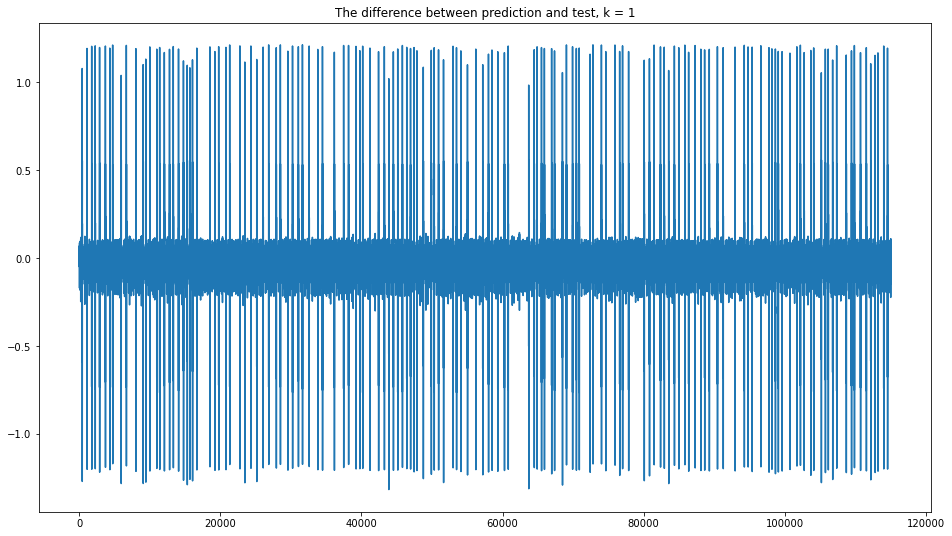

In [124]:
plt.figure(figsize = (16, 9))
plt.plot(dif)
plt.title("The difference between prediction and test, k = 1")

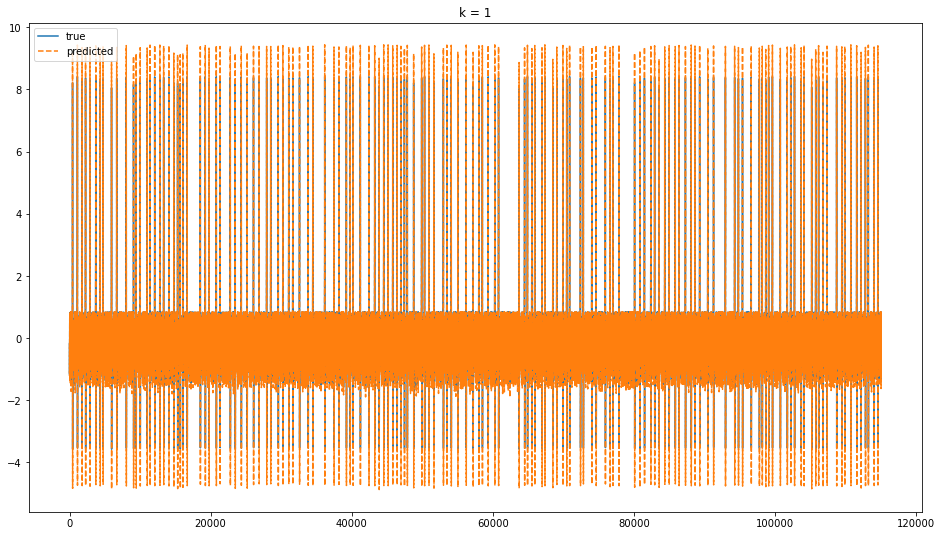

In [125]:
plt.figure(figsize = (16, 9))
plt.plot(test_norm, label='true')
plt.plot(np.array(predicted)[:, 0],  linestyle = '--', label='predicted')
plt.title("k = 1")
plt.legend()

In [102]:
((((np.array(predicted)[:, 0]*std+mean) - test)**2).mean())**0.5

0.013307889663577802

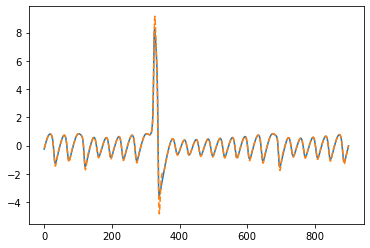

In [103]:
plt.plot(test_norm[100:1000])
plt.plot(np.array(predicted)[:, 0][100:1000],  linestyle = '--')

# Lienard

In [126]:
data = np.loadtxt("./lienard_intermittency.dat")


train = data[:, 1][:45000]
test =  data[:, 1][45000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std
train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [66]:
# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=1,      # Размер вектора состояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 1х1
filter.F = np.array([[1.0]])


# Матрица наблюдения - dim_z на dim_x - 1x1
filter.H = np.array([[1.0]])

# Ковариационная матрица ошибки модели
filter.Q = processNoise 

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[8.0]])

In [67]:
for i in range(len(train_norm)):
    filter.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    filter.predict()
    filter.update(test_norm[j])    
    predicted.append(filter.x)


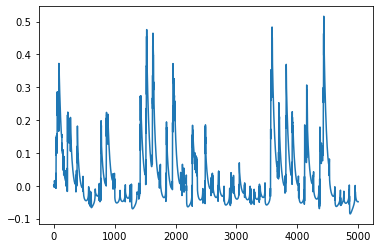

In [68]:
plt.plot(predicted)

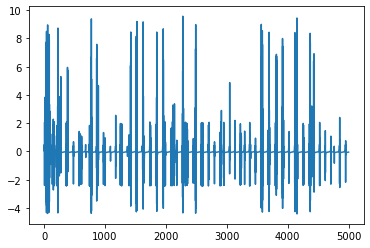

In [69]:
plt.plot(test_norm)

In [70]:
# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=2,      # Размер вектора стостояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 2х2
filter.F = np.array([[1,   dt],
                     [0,   1.0]])


# Матрица наблюдения - dim_z на dim_x - 1x2
filter.H = np.array([[1.0, 0.0]])

filter.Q = np.array([[dt**2,       dt],
           [   dt,      1.0]]) * processNoise

# Начальное состояние.
filter.x = np.array([0.0, 0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[8.0, 0.0],
                    [0.0, 8.0]])

In [71]:
for i in range(len(train_norm)):
    filter.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    filter.predict()
    filter.update(test_norm[j])    
    predicted.append(filter.x)


In [72]:
((((np.array(predicted)[:, 0]*std+mean) - test)**2).mean())**0.5

0.2934178656190697

In [127]:
# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=3,      # Размер вектора стостояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 3х3
filter.F = np.array([[1.,   dt,     (dt**2)/2],
                     [0,   1.,    dt],
                     [0,   0,      1.]])


# Матрица наблюдения - dim_z на dim_x - 1x3
filter.H = np.array([[1., 0., 0.]])

# Ковариационная матрица ошибки модели
filter.Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt, var=processNoiseVariance)

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0, 0.0, 0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])

In [128]:
for i in range(len(train_norm)):
    filter.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    filter.predict()
    filter.update(test_norm[j])    
    predicted.append(filter.x)


In [129]:
dif = np.array(predicted)[:, 0] - np.array(test_norm)

Text(0.5, 1.0, 'The difference between prediction and test, k = 1')

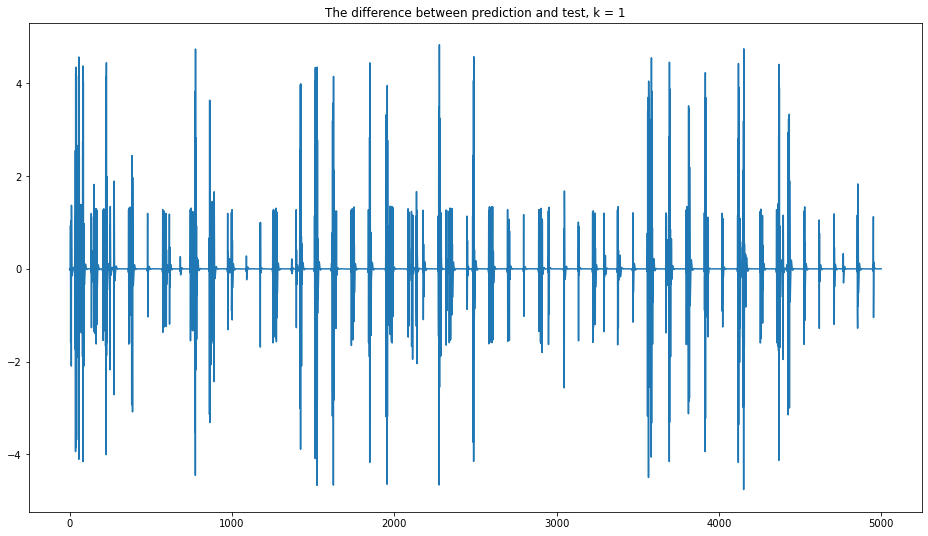

In [130]:
plt.figure(figsize = (16, 9))
plt.plot(dif)
plt.title("The difference between prediction and test, k = 1")

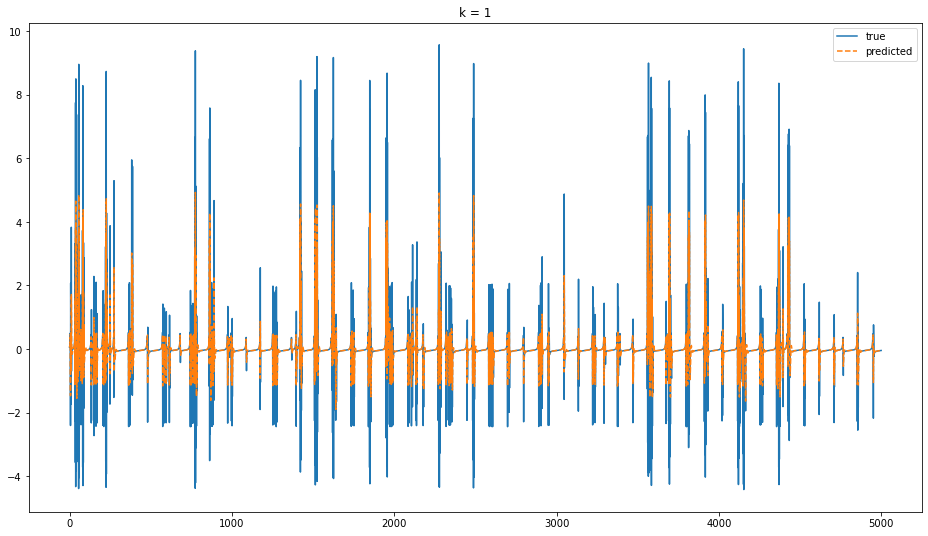

In [131]:
plt.figure(figsize = (16, 9))
plt.plot(test_norm, label='true')
plt.plot(np.array(predicted)[:, 0],  linestyle = '--', label='predicted')
plt.title("k = 1")
plt.legend()

In [75]:
((((np.array(predicted)[:, 0]*std+mean) - test)**2).mean())**0.5

0.20667971082906947

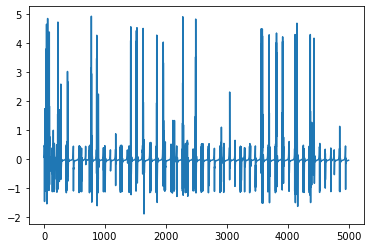

In [77]:
plt.plot(np.array(predicted)[:, 0])

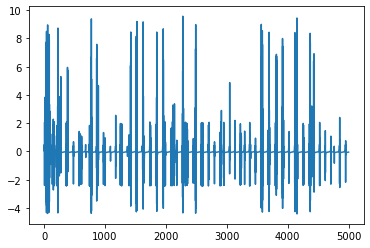

In [78]:
plt.plot(test_norm)

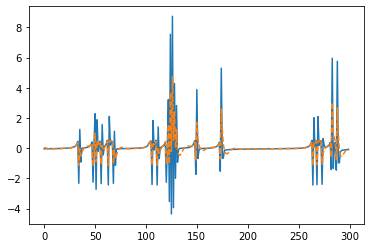

In [87]:
plt.plot(test_norm[100:400])
plt.plot(np.array(predicted)[:, 0][100:400],  linestyle = '--')

# NonLinear FHN

In [105]:
def FHN(self, X):
        x1, y1, x2, y2 = X
        return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                b1*x1 - c*y1,
                x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                b2*x2 - c*y2
               ]

In [106]:
a = -0.025794
c = 0.02
b1 = 0.0135
b2 = 0.0065
k = 0.129
sigma = 1
alpha = 0.35
eps = 1
beta = 10e-8
q=1.6

In [107]:
sol = solve_ivp(FHN, [0, 250000], [-0.1, 0.1, -0.1, -0.1], 
                t_eval=np.array(range(0, 250000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

In [108]:
data = sol.y[0]

train = data[:10000]
test =  data[10000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std
train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [131]:
def measurementFunction(x):
    return np.array([x[0]])

# Функция процесса - аналог матрицы процесса
def stateTransitionFunction(x, dt):
    newState = np.zeros(4)
    newState[0] = x[0]*(a-x[0])*(x[0]-1) - x[1] + k*(x[2] - x[0])
    newState[1] = b1 * x[0] - c * x[1]
    newState[2] = x[2]*(a-x[2])*(x[2]-1) - x[3] + k*(x[0] - x[2])
    newState[3] = b2 * x[2] - c * x[3]

    return newState


# Для unscented kalman filter необходимо выбрать алгоритм выбора сигма-точек
points = filterpy.kalman.JulierSigmaPoints(4, kappa=0)

# Создаём объект UnscentedKalmanFilter
filter = filterpy.kalman.UnscentedKalmanFilter(dim_x = 4,
                                              dim_z = 1,
                                              dt = dt,
                                              hx = measurementFunction,
                                              fx = stateTransitionFunction,
                                              points = points)



# Ковариационная матрица ошибки модели
filter.Q = filterpy.common.Q_discrete_white_noise(dim=4, dt=dt, var=processNoiseVariance)

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0, 0.0, 0.0, 0.])

# Ковариационная матрица для начального состояния
filter.P = np.array([[1.0, 0.0,  0.0, 0.],
                    [0.0,  1.0, 0.0, 0.],
                    [0.0,  0.0,  1.0, 0.],
                    [0.0,  0.0,  0.0, 1.]])

In [134]:
filter.P

array([[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         9.90352031e+027],
       [ 0.00000000e+000,  4.45596667e-004,  9.31197758e+065,
         4.60000000e+001],
       [ 0.00000000e+000,  9.31197758e+065,  4.53251574e+140,
         5.78960446e+076],
       [ 9.90352031e+027,  4.60000000e+001,  8.68440669e+076,
        -6.18970020e+026]])

In [132]:
for i in range(len(train_norm)):
    #print(filter.x)
    #filter.predict()
    filter.update(train_norm[i])
predicted = []
for j in range(len(test_norm)):
    #print(j)
    filter.predict()
    filter.update([test_norm[j]])    
    predicted.append(filter.x)


LinAlgError: 1-th leading minor of the array is not positive definite

In [133]:
np.array(predicted)[:,0]

array([-0.16337391, -0.30716827, -0.75337492, -0.97795224,  0.        ])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

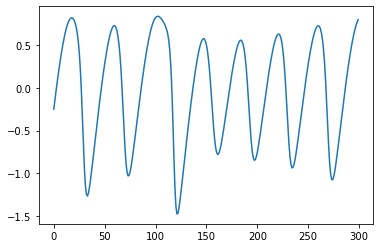

In [122]:
plt.plot(test_norm[100:400])
plt.plot(np.array(predicted)[:, 0][100:400],  linestyle = '--')

In [ ]:
((((np.array(predicted)[:, 0]*std+mean) - test)**2).mean())**0.5